In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import shutil
import random


dtype_dict = {
    'iddx_5': str,  
    'mel_mitotic_index': str,
}

image_folder_path = '/kaggle/input/skin-cancer-detection-dataset/train-image/image'
csv_file_path = '/kaggle/input/skin-cancer-detection-dataset/train-metadata.csv'

# Load CSV data
meta_data = pd.read_csv(csv_file_path, low_memory=False)
# meta_data['iddx_3'] = meta_data['iddx_3'].astype(str)  # Convert to string
# meta_data['iddx_4'] = meta_data['iddx_4'].astype(str)

#Sampling first 5 rows
meta_data[:5]

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [2]:
#Speciying X and y sets
X = meta_data.drop('target', axis = 1)
y = meta_data['target']

# DATA LOADING AND VISUALIZATION

In [3]:
# Function to load a sample of images
def load_image_sample(image_folder, sample_size=100):
    
    #listing all images in target folder
    all_images = os.listdir(image_folder)
    
    #choose sample_size no. of images randomly while not replacing them again
    sample_images = np.random.choice(all_images, sample_size, replace=False)
    
    #np array to store the images
    images = []
    
        
    for img_name in sample_images:
        #making complete path of images including path of dir and the img
        img_path = os.path.join(image_folder, img_name)
        img = Image.open(img_path)
        
        #change the image from jpg to np array
        images.append(np.array(img))
    return images, sample_images


image_folder = '/kaggle/input/skin-cancer-detection-dataset/train-image/image'
images, sampled_image_names = load_image_sample(image_folder, sample_size=100)


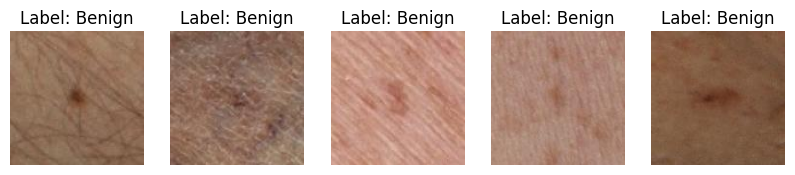

In [4]:
#function to display the loaded images
def visualize_random_images(images, meta_data, sample_image_names, num_images=5):
    plt.figure(figsize=(10, 10))
    
    # giving appropriate label
    label_mapping = {0: 'Benign', 1: 'Malignant'} 
    
    for i in range(num_images):
        #makes a subplot of 1 row having num_images no. of images
        plt.subplot(1, num_images, i + 1)
        
        #randomly select any image
        random_idx = np.random.randint(0, len(images))
        plt.imshow(images[random_idx])
        
        # Remove file extension
        img_name = os.path.splitext(sample_image_names[random_idx])[0]  
        img_label = meta_data[meta_data['isic_id'] == img_name]['target'].values[0]
        
        numerical_label = meta_data[meta_data['isic_id'] == img_name]['target'].values[0]
        img_label = label_mapping.get(numerical_label)
        
        plt.title(f"Label: {img_label}")
        plt.axis('off')
        
    plt.show()

visualize_random_images(images, meta_data, sampled_image_names)


Class distribution:
target
0    400666
1       393
Name: count, dtype: int64


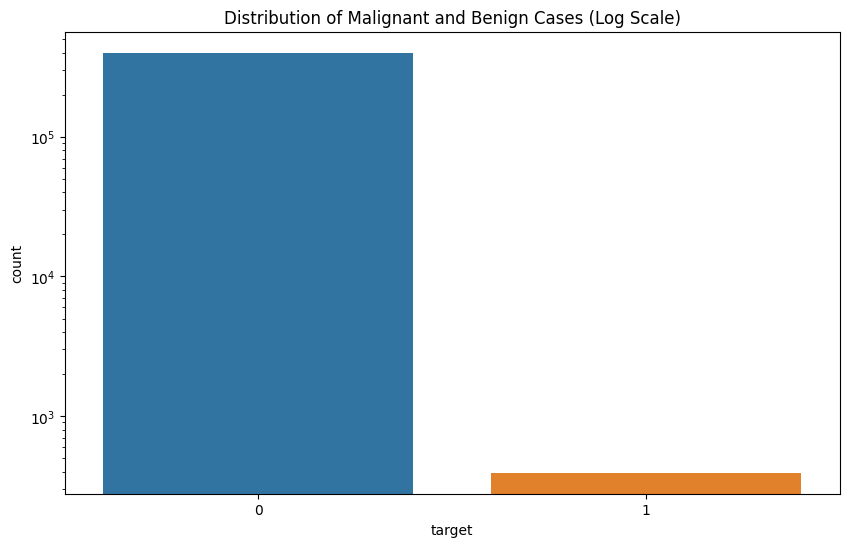

In [5]:
# Count the occurrences of each class
class_counts = meta_data['target'].value_counts()

print("Class distribution:")
print(class_counts)

# Create a countplot with log scale on the y-axis bcz of less no. of malignant cases
plt.figure(figsize=(10, 6))
sns.countplot(data=meta_data, x='target')
plt.yscale('log')  # Apply logarithmic scale to the y-axis
plt.title('Distribution of Malignant and Benign Cases (Log Scale)')
plt.show()

In [6]:
import numpy as np

def get_image_dimensions(images):
    dimensions = []
    
    for img in images:
            # Get dimensions (height, width, channels) of the image
            if len(img.shape) >= 2:
                height, width = img.shape[:2]  # Handle grayscale and RGB images
                dimensions.append((width, height))
            else:
                print("Warning: Image array does not have expected shape:", img.shape)
    
    return np.array(dimensions)

image_dimensions = get_image_dimensions(images)

# Calculate basic statistics
mean_dimensions = np.mean(image_dimensions, axis=0)
std_dimensions = np.std(image_dimensions, axis=0)

print(f"Mean dimensions (width, height): {mean_dimensions}")
print(f"Standard deviation of dimensions (width, height): {std_dimensions}")


Mean dimensions (width, height): [132.6 132.6]
Standard deviation of dimensions (width, height): [19.08088048 19.08088048]


Basic statistics for patient age:
count    398261.000000
mean         58.012986
std          13.596165
min           5.000000
25%          50.000000
50%          60.000000
75%          70.000000
max          85.000000
Name: age_approx, dtype: float64
Distribution of lesion locations:
tbp_lv_location
Torso Back Top Third       71112
Torso Front Top Half       63350
Torso Back Middle Third    46185
Left Leg - Lower           27428
Right Leg - Lower          25208
Torso Front Bottom Half    24360
Left Leg - Upper           23673
Right Leg - Upper          23034
Right Arm - Upper          22972
Left Arm - Upper           22816
Head & Neck                12046
Left Arm - Lower           11939
Right Arm - Lower          10636
Unknown                     5756
Torso Back Bottom Third     4596
Left Leg                    1974
Right Leg                   1711
Left Arm                    1593
Right Arm                    601
Torso Front                   60
Torso Back                     9
Name: 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


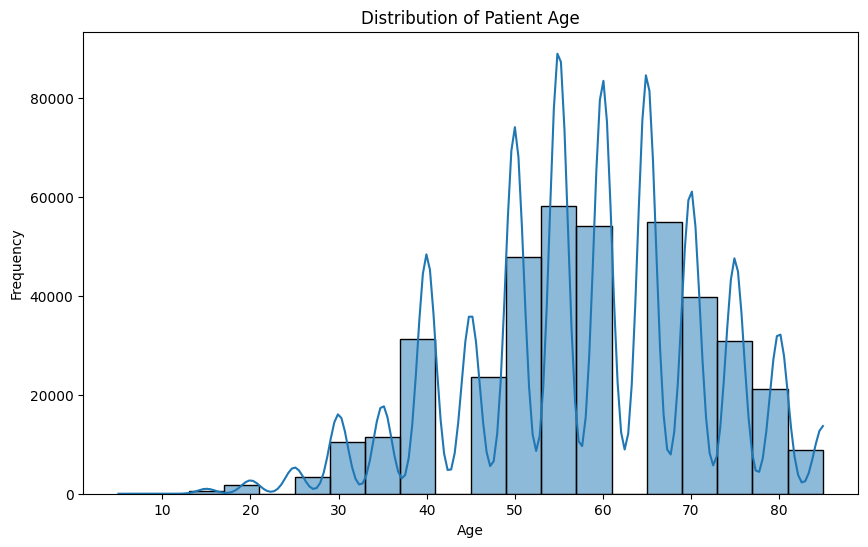

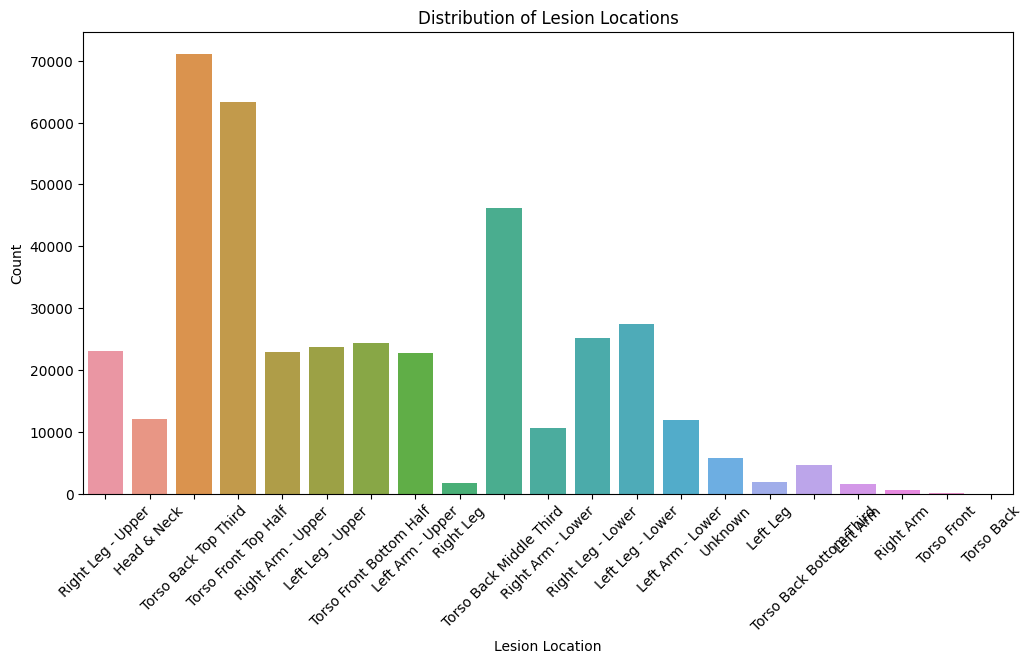

In [7]:
# Basic statistics
print("Basic statistics for patient age:")
print(meta_data['age_approx'].describe())  # Assuming 'age' is the column name for patient age

# Distribution of lesion location
print("Distribution of lesion locations:")
print(meta_data['tbp_lv_location'].value_counts())  # Assuming 'lesion_location' is the column name

# Example visualizations
# Histogram of patient age
plt.figure(figsize=(10, 6))
sns.histplot(meta_data['age_approx'].dropna(), bins=20, kde=True)
plt.title('Distribution of Patient Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Bar plot of lesion locations
plt.figure(figsize=(12, 6))
sns.countplot(data=meta_data, x='tbp_lv_location')  # Assuming 'lesion_location' is the column name
plt.title('Distribution of Lesion Locations')
plt.xlabel('Lesion Location')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


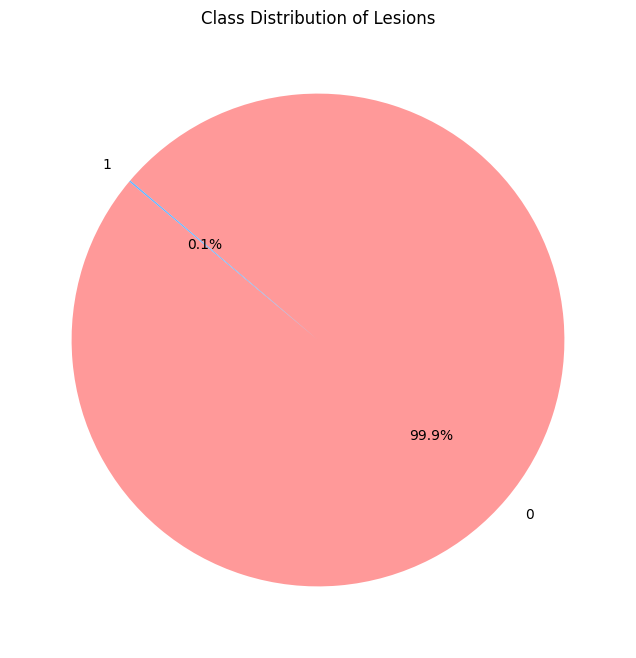

In [8]:
# Pie chart for class distribution
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Class Distribution of Lesions')
plt.show()

# DATA CLEANING

In [9]:
meta_data['sex'].replace(np.nan, 'Unknown', inplace=True)
meta_data[:5]

/tmp/ipykernel_34/3709496133.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  meta_data['sex'].replace(np.nan, 'Unknown', inplace=True)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [10]:
unknown_sex_rows = meta_data[meta_data['sex'] == 'Unknown']

print(unknown_sex_rows)

             isic_id  target  patient_id  age_approx      sex  \
57      ISIC_0073511       0  IP_3371534         NaN  Unknown   
60      ISIC_0073555       0  IP_3371534         NaN  Unknown   
63      ISIC_0073672       0  IP_6187331        55.0  Unknown   
72      ISIC_0073934       0  IP_9472195        55.0  Unknown   
132     ISIC_0076435       0  IP_2914511        30.0  Unknown   
...              ...     ...         ...         ...      ...   
400728  ISIC_9992252       0  IP_7703522        40.0  Unknown   
400826  ISIC_9994379       0  IP_1822913        35.0  Unknown   
400844  ISIC_9994715       0  IP_0473747        55.0  Unknown   
400983  ISIC_9998324       0  IP_1474479        70.0  Unknown   
401032  ISIC_9999386       0  IP_1474479        70.0  Unknown   

       anatom_site_general  clin_size_long_diam_mm          image_type  \
57         lower extremity                    4.17  TBP tile: close-up   
60         posterior torso                    2.76  TBP tile: close-up 

In [11]:
meta_data['anatom_site_general'].replace(np.nan, 'Unknown', inplace=True)

unknown_site_rows = meta_data[meta_data['anatom_site_general'] == 'Unknown']
print(unknown_site_rows)

             isic_id  target  patient_id  age_approx     sex  \
73      ISIC_0073937       0  IP_1127121        65.0    male   
77      ISIC_0074075       0  IP_1127121        65.0    male   
136     ISIC_0076516       0  IP_1127121        65.0    male   
333     ISIC_0081327       0  IP_2988802        50.0  female   
399     ISIC_0083144       0  IP_1219465        85.0  female   
...              ...     ...         ...         ...     ...   
400784  ISIC_9993409       0  IP_9011000        50.0    male   
400787  ISIC_9993536       0  IP_1127121        65.0    male   
400829  ISIC_9994464       0  IP_1127121        65.0    male   
400974  ISIC_9997925       0  IP_4295424        50.0  female   
401036  ISIC_9999435       0  IP_3487012        75.0    male   

       anatom_site_general  clin_size_long_diam_mm          image_type  \
73                 Unknown                    3.70  TBP tile: close-up   
77                 Unknown                    4.25  TBP tile: close-up   
136      

/tmp/ipykernel_34/511460414.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  meta_data['anatom_site_general'].replace(np.nan, 'Unknown', inplace=True)


In [12]:
mod_data = meta_data.drop(['lesion_id', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index', 'mel_thick_mm'], axis = 1)

In [13]:
mod_data.isna()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,iddx_full,iddx_1,tbp_lv_dnn_lesion_confidence
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
401055,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
401056,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
401057,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
# Summary of missing values per column
missing_summary = mod_data.isna().sum()
print("Summary of missing values per column:")
print(missing_summary)

Summary of missing values per column:
isic_id                            0
target                             0
patient_id                         0
age_approx                      2798
sex                                0
anatom_site_general                0
clin_size_long_diam_mm             0
image_type                         0
tbp_tile_type                      0
tbp_lv_A                           0
tbp_lv_Aext                        0
tbp_lv_B                           0
tbp_lv_Bext                        0
tbp_lv_C                           0
tbp_lv_Cext                        0
tbp_lv_H                           0
tbp_lv_Hext                        0
tbp_lv_L                           0
tbp_lv_Lext                        0
tbp_lv_areaMM2                     0
tbp_lv_area_perim_ratio            0
tbp_lv_color_std_mean              0
tbp_lv_deltaA                      0
tbp_lv_deltaB                      0
tbp_lv_deltaL                      0
tbp_lv_deltaLB                     0


In [15]:
mod_data = mod_data.dropna(subset=['age_approx'])

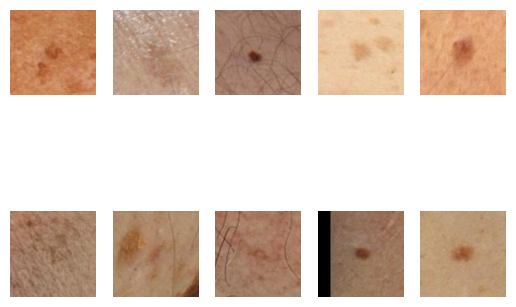

In [33]:
import albumentations as A

# Define the source and destination directories
source_dir = '/kaggle/input/skin-cancer-detection-dataset/train-image/image'
destination_dir = '/kaggle/working/processed_images'

# Ensure the destination directory exists
os.makedirs(destination_dir, exist_ok=True)

# Filter for images with target value 0
target0 = mod_data[mod_data['target'] == 0]

# Extract image names and target values
image_names = target0['isic_id'].astype(str) + '.jpg'
targets = target0['target']

# Create a dictionary of image names and their corresponding target values
image_target_dict = dict(zip(image_names, targets))

# Select 1000 random images
selected_files = random.sample(image_names.tolist(), 1000)

# Define the augmentation pipeline
transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.Flip(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.5, rotate_limit=45, p=0.2),
    A.HueSaturationValue(p=0.3),
])

# Resize and transfer the selected images to the destination directory
resize_size = (224, 224)

# Dictionary to store target values of processed images
processed_targets = {}

for file_name in selected_files:
    source_file = os.path.join(source_dir, file_name)
    destination_file = os.path.join(destination_dir, file_name)

    try:
        # Open the image
        with Image.open(source_file) as img:
            img = np.array(img)
            augmented = transform(image=img)
            augmented_img = augmented['image']
            resized_img = Image.fromarray(augmented_img).resize(resize_size)
            
            # Save the augmented and resized image to the destination directory
            resized_img.save(destination_file)
            
            # Store the target value of the processed image
            processed_targets[file_name] = image_target_dict[file_name]

    except Exception as e:
        print(f"Error processing file {file_name}: {e}")

# Display the augmented images
processed_images = [os.path.join(destination_dir, file) for file in selected_files]

# Display a few images using matplotlib
for i, img_path in enumerate(processed_images[:10]):  # Display first 10 images
    try:
        img = Image.open(img_path)
        plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
        plt.imshow(img)
        plt.axis('off')
    except Exception as e:
        print(f"Error displaying image {img_path}: {e}")

plt.show()


In [84]:
# # Check and print the size of each resized image
# for file_name in processed_images[:10]:
#     resized_file = os.path.join(destination_dir, file_name)
#     with Image.open(resized_file) as img:
#         print(f"Image: {file_name}, Size: {img.size}")
        
        

augmented_dir = '/kaggle/working/augmented_images'

# Get a list of all files in the directory
file_names = os.listdir(augmented_dir)

# Check and print the size of each image
for file_name in file_names[:10]:
    resized_file = os.path.join(augmented_dir, file_name)
    try:
        with Image.open(resized_file) as img:
            print(f"Image: {file_name}, Size: {img.size}")
    except Exception as e:
        print(f"Error opening file {file_name}: {e}")


Image: ISIC_7967509.jpg, Size: (224, 224)
Image: ISIC_1786961_aug_0.jpg, Size: (224, 224)
Image: ISIC_9953962.jpg, Size: (224, 224)
Image: ISIC_9345939.jpg, Size: (224, 224)
Image: ISIC_1707995.jpg, Size: (224, 224)
Image: ISIC_8078557.jpg, Size: (224, 224)
Image: ISIC_3521698_aug_0.jpg, Size: (224, 224)
Image: ISIC_4954780_aug_1.jpg, Size: (224, 224)
Image: ISIC_3043703.jpg, Size: (224, 224)
Image: ISIC_3398864.jpg, Size: (224, 224)


# EMPTYING A DIRECTORY

In [29]:
def empty_directory(directory_path):
    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"The directory {directory_path} does not exist.")
        return

    # Iterate over all the files and subdirectories in the specified directory
    for item_name in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item_name)
        
        if os.path.isfile(item_path) or os.path.islink(item_path):
            # Remove files and symbolic links
            os.remove(item_path)
        elif os.path.isdir(item_path):
            # Remove directories and their contents
            shutil.rmtree(item_path)

    print(f"The directory {directory_path} has been emptied.")

# Specify the directory to be emptied
directory_to_empty = '/kaggle/working/augmented_images'
a = '/kaggle/working/split_images'
# b = '/kaggle/working/processed_images/val'

# Empty the directory
empty_directory(directory_to_empty)
empty_directory(a)
# empty_directory('/kaggle/working/split_images')

The directory /kaggle/working/augmented_images has been emptied.
The directory /kaggle/working/split_images has been emptied.


# DELETING A DIRECTORY

In [32]:
directory_to_delete = '/kaggle/working/split_images'
# Delete the directory and its contents
shutil.rmtree(directory_to_delete)
print(f"Directory '{directory_to_delete}' has been deleted.")

Directory '/kaggle/working/split_images' has been deleted.


# SPLITTING DATA

In [35]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the source directories
augmented_dir = '/kaggle/working/augmented_images'  # Directory with augmented images (target 1)
processed_dir = '/kaggle/working/processed_images'  # Directory with original images (target 0)

# Define the destination base directory
base_destination_dir = '/kaggle/working/split_images'

# Ensure the destination directories exist with subdirectories for labels
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_destination_dir, split, '0'), exist_ok=True)
    os.makedirs(os.path.join(base_destination_dir, split, '1'), exist_ok=True)

# Get a list of all files in both source directories
augmented_files = [os.path.join(augmented_dir, f) for f in os.listdir(augmented_dir)]
processed_files = [os.path.join(processed_dir, f) for f in os.listdir(processed_dir)]
all_files = augmented_files + processed_files

# Function to extract label from filename
def get_label_from_filename(filename):
    if 'aug' in filename:
        return 1  # Augmented images are labeled as 1
    else:
        return 0  # Processed images are labeled as 0

# Create a dictionary to hold file paths and their labels
file_label_dict = {file: get_label_from_filename(os.path.basename(file)) for file in all_files}

# Split the data into train, validation, and test sets
train_files, test_files = train_test_split(list(file_label_dict.keys()), test_size=0.2, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Function to copy files to their respective directories
def copy_files(file_list, destination_dir):
    for file_path in file_list:
        file_name = os.path.basename(file_path)
        label = file_label_dict[file_path]
        dst_path = os.path.join(destination_dir, str(label), file_name)
        try:
            shutil.copy(file_path, dst_path)
        except FileNotFoundError as e:
            print(f"Error: {e}")

# Copy the files to the respective directories
copy_files(train_files, os.path.join(base_destination_dir, 'train'))
copy_files(val_files, os.path.join(base_destination_dir, 'val'))
copy_files(test_files, os.path.join(base_destination_dir, 'test'))

print("Files copied successfully!")


Files copied successfully!


# DATA AUGMENTATION FOR MINORITY CLASS

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, save_img
from tensorflow.keras.preprocessing import image
from PIL import Image as PILImage

# Define paths and settings
dataset_dir = '/kaggle/input/skin-cancer-detection-dataset/train-image/image'  # Base directory containing images
num_augmented_per_image = 3  # Number of augmented images per original image
augmented_dir = '/kaggle/working/augmented_images'
resize_size = (224, 224)  # Desired resize size

# Create the directory if it doesn't exist
if not os.path.exists(augmented_dir):
    try:
        os.makedirs(augmented_dir)
        print(f"Directory created: {augmented_dir}")
    except Exception as e:
        print(f"Error creating directory: {e}")

# Define the image data generator for augmentation
aug_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a dictionary to store the target values of augmented images
augmented_targets = {}

def augment_images(df, base_dir, num_augmented_per_image, augmented_dir):
    # Filter for images with label 1
    label_1_df = df[df['target'] == 1]
    
    for _, row in label_1_df.iterrows():
        img_name = row['isic_id']
        img_path = os.path.join(base_dir, img_name + '.jpg')
        
        # Check if the file exists
        if not os.path.isfile(img_path):
            print(f"File not found: {img_path}")
            continue
        
        img = image.load_img(img_path)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        
        # Generate augmented images
        i = 0
        for batch in aug_datagen.flow(img_array, batch_size=1):
            aug_img = batch[0].astype(np.uint8)
            # Resize the image
            resized_img = PILImage.fromarray(aug_img).resize(resize_size)
            
            # Generate a unique filename for each augmented image
            aug_img_filename = f"{img_name}_aug_{i}.jpg"
            aug_img_path = os.path.join(augmented_dir, aug_img_filename)
            resized_img.save(aug_img_path)
            
            # Store the target value of the augmented image
            augmented_targets[aug_img_filename] = row['target']
            
            i += 1
            if i >= num_augmented_per_image:
                break

# Augment images with label 1
augment_images(mod_data, dataset_dir, num_augmented_per_image, augmented_dir)

print("Data augmentation and resizing complete!")

# The `augmented_targets` dictionary now holds the target values for the augmented images


Directory created: /kaggle/working/augmented_images
Data augmentation and resizing complete!


# USING PRE TRAINED MODELS

In [36]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image

# Step 2: Set up GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

# Step 3: Import Libraries
# Initialize ResNet50 model without pre-trained weights
resnet_model = ResNet50(weights=None, include_top=False, pooling='avg')

# Load the manually downloaded weights
weights_path = '/kaggle/input/pre-trained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'  # Replace with the path to your weights file
resnet_model.load_weights(weights_path)

def extract_features(image_path, resnet_model):
    # Load and preprocess the image for ResNet50
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = resnet_preprocess_input(img_array)
    
    # Extract features using ResNet50
    resnet_features = resnet_model.predict(img_array)
    
    return resnet_features.flatten()  # Flatten the features if necessary

def extract_features_from_directory(source_dir, resnet_model, output_file):
    feature_list = []
    file_names = []

    # Walk through the directory
    for root, dirs, files in os.walk(source_dir):
        for file_name in files:
            image_path = os.path.join(root, file_name)
            if os.path.isfile(image_path):  # Ensure it's a file
                try:
                    features = extract_features(image_path, resnet_model)
                    feature_list.append(features)
                    # Save relative path to preserve directory structure
                    relative_path = os.path.relpath(image_path, source_dir)
                    file_names.append(relative_path)
                except Exception as e:
                    print(f"Error processing file {file_name}: {e}")

    # Save features to a file
    np.savez(output_file, features=np.array(feature_list), file_names=file_names)

# Example usage
source_dir = '/kaggle/working/split_images'  # Replace with your directory
extract_features_from_directory(source_dir, resnet_model, 'combined_features.npz')


1 Physical GPUs, 1 Logical GPUs
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━

# VERIFYING FEATURE EXTRACTION

In [37]:
# Load and check the saved features
npzfile = np.load('combined_features.npz')
features = npzfile['features']
file_names = npzfile['file_names']

print(f'Features shape: {features.shape}')
# print(f'File names: {file_names}')

Features shape: (2170, 2048)


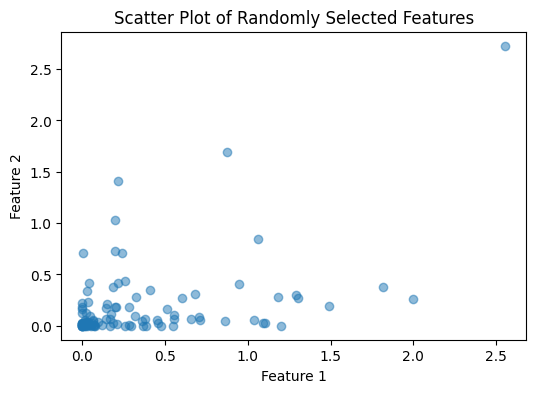

In [24]:
# Randomly select a subset of feature vectors to plot
num_samples = 100
indices = np.random.choice(len(features), num_samples, replace=False)

# Get the selected features
selected_features = features[indices]

# Plot the first two features (or any two features) for these samples
plt.figure(figsize=(6, 4))
plt.scatter(selected_features[:, 0], selected_features[:, 1], alpha=0.5)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Randomly Selected Features')
plt.show()


# COLOR HISTOGRAM

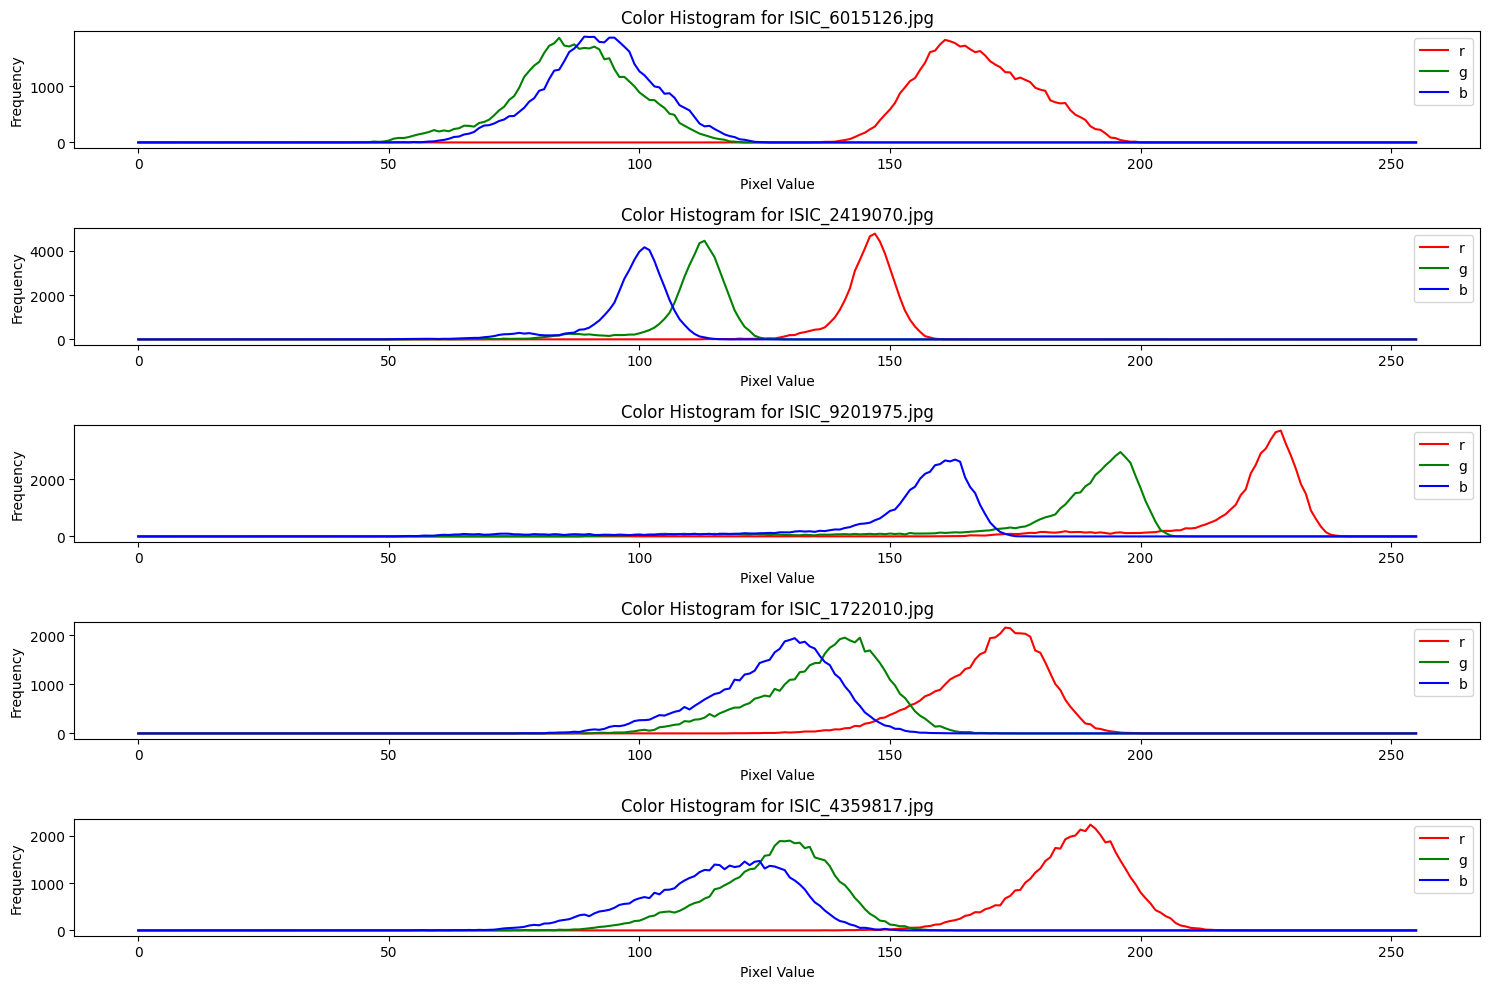

In [166]:
import cv2

# Path to the base folder containing images in subdirectories
base_folder_path = '/kaggle/working/processed_images'

def list_images_in_subdirectories(base_folder_path):
    image_files = []
    for subdir, _, files in os.walk(base_folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Adjust extensions as needed
                image_files.append(os.path.join(subdir, file))
    return image_files

# List all images in the subdirectories
image_files = list_images_in_subdirectories(base_folder_path)

# Ensure there are enough images to select
num_images_to_plot = 5
if len(image_files) < num_images_to_plot:
    raise ValueError("Not enough images to select from.")

# Select a subset of images to plot
selected_images = np.random.choice(image_files, num_images_to_plot, replace=False)

# Create subplots
plt.figure(figsize=(15, 10))

for idx, image_path in enumerate(selected_images):
    # Load the image
    image = cv2.imread(image_path)
    
    # Check if image is loaded successfully
    if image is None:
        print(f"Error loading image: {image_path}")
        continue
    
    # Convert to RGB (OpenCV loads images in BGR format by default)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Compute histograms for each channel
    channels = ('r', 'g', 'b')
    plt.subplot(num_images_to_plot, 1, idx + 1)
    for i, channel in enumerate(channels):
        histogram = cv2.calcHist([image_rgb], [i], None, [256], [0, 256])
        plt.plot(histogram, color=channel, label=channel)
    
    plt.title(f'Color Histogram for {os.path.basename(image_path)}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()

# Adjust layout and show plots
plt.tight_layout()
plt.show()


# DESCRIBING LOCAL TEXTURE USING LBP

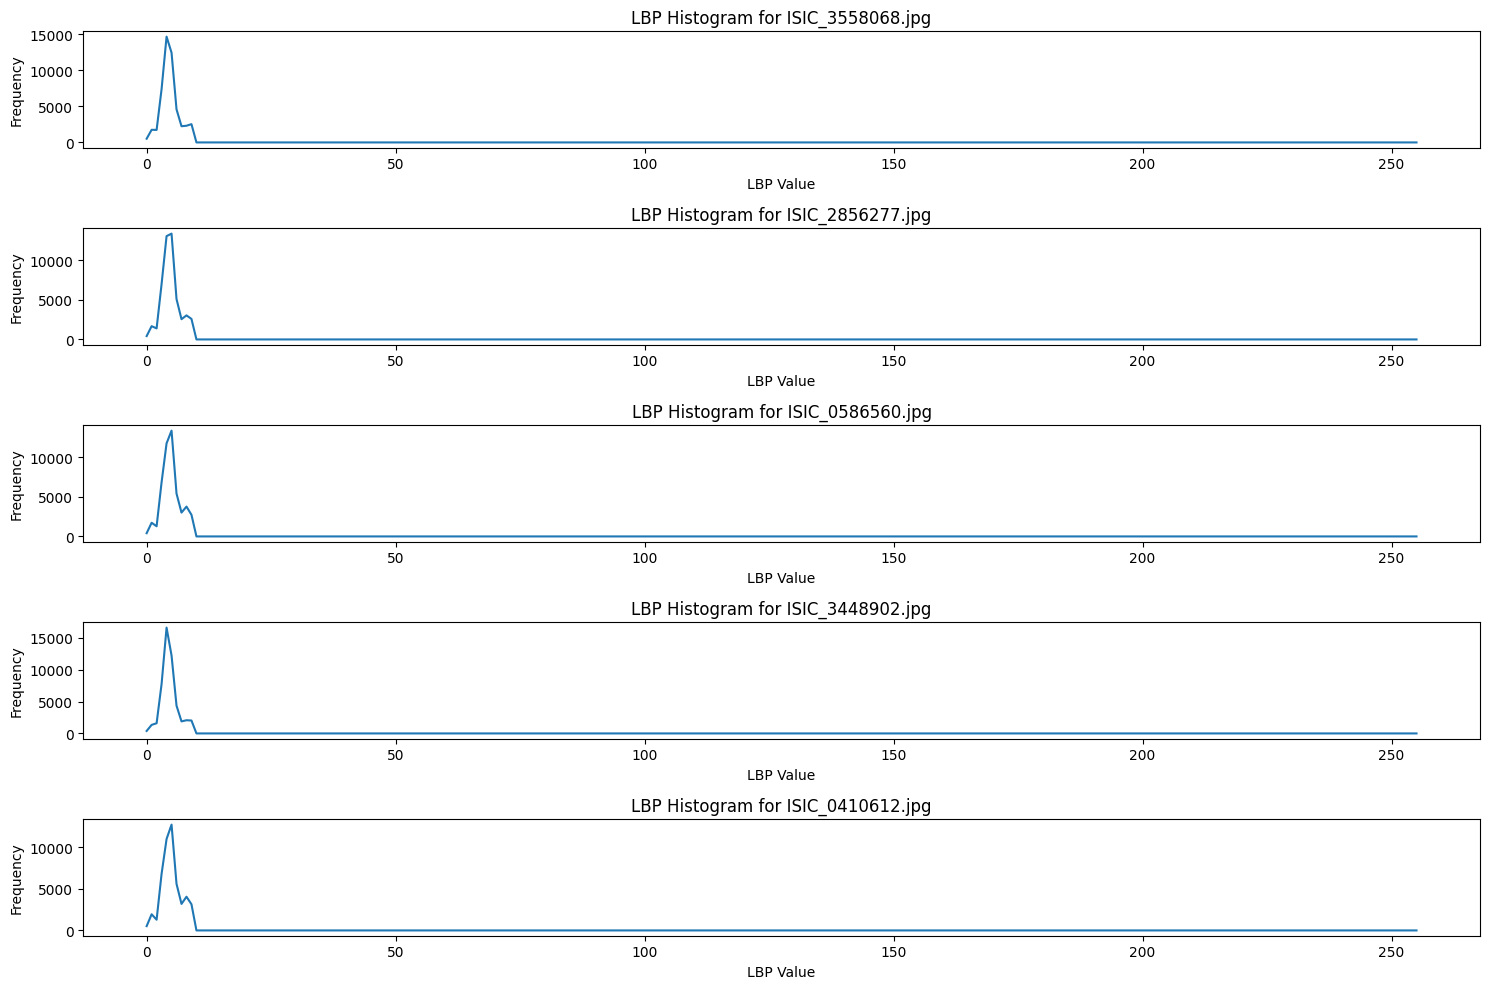

In [167]:
from skimage.feature import local_binary_pattern
from skimage import exposure
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

# Define directories
processed_images_dir = '/kaggle/working/processed_images'
augmented_images_dir = '/kaggle/working/augmented_images'
num_images_to_plot = 5  # Define how many images you want to plot

# Combine processed and augmented images
processed_images = os.listdir(processed_images_dir)
augmented_images = os.listdir(augmented_images_dir)
selected_images = processed_images[:num_images_to_plot] + augmented_images[:num_images_to_plot]

# Ensure the total number of images does not exceed the desired number
selected_images = selected_images[:num_images_to_plot]

# Create subplots
plt.figure(figsize=(15, 10))

for idx, image_file in enumerate(selected_images):
    # Determine if the image is from processed or augmented directory
    if image_file in processed_images:
        image_path = os.path.join(processed_images_dir, image_file)
    else:
        image_path = os.path.join(augmented_images_dir, image_file)
    
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute LBP
    lbp = local_binary_pattern(gray_image, P=8, R=1, method='uniform')
    
    # Compute histogram of LBP
    lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 2**8 + 1), range=(0, 2**8))
    
    # Plot LBP histogram
    plt.subplot(num_images_to_plot, 1, idx + 1)
    plt.plot(lbp_hist, label='LBP Histogram')
    plt.title(f'LBP Histogram for {image_file}')
    plt.xlabel('LBP Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# CONTOUR BASED SHAPE DEPICTORS

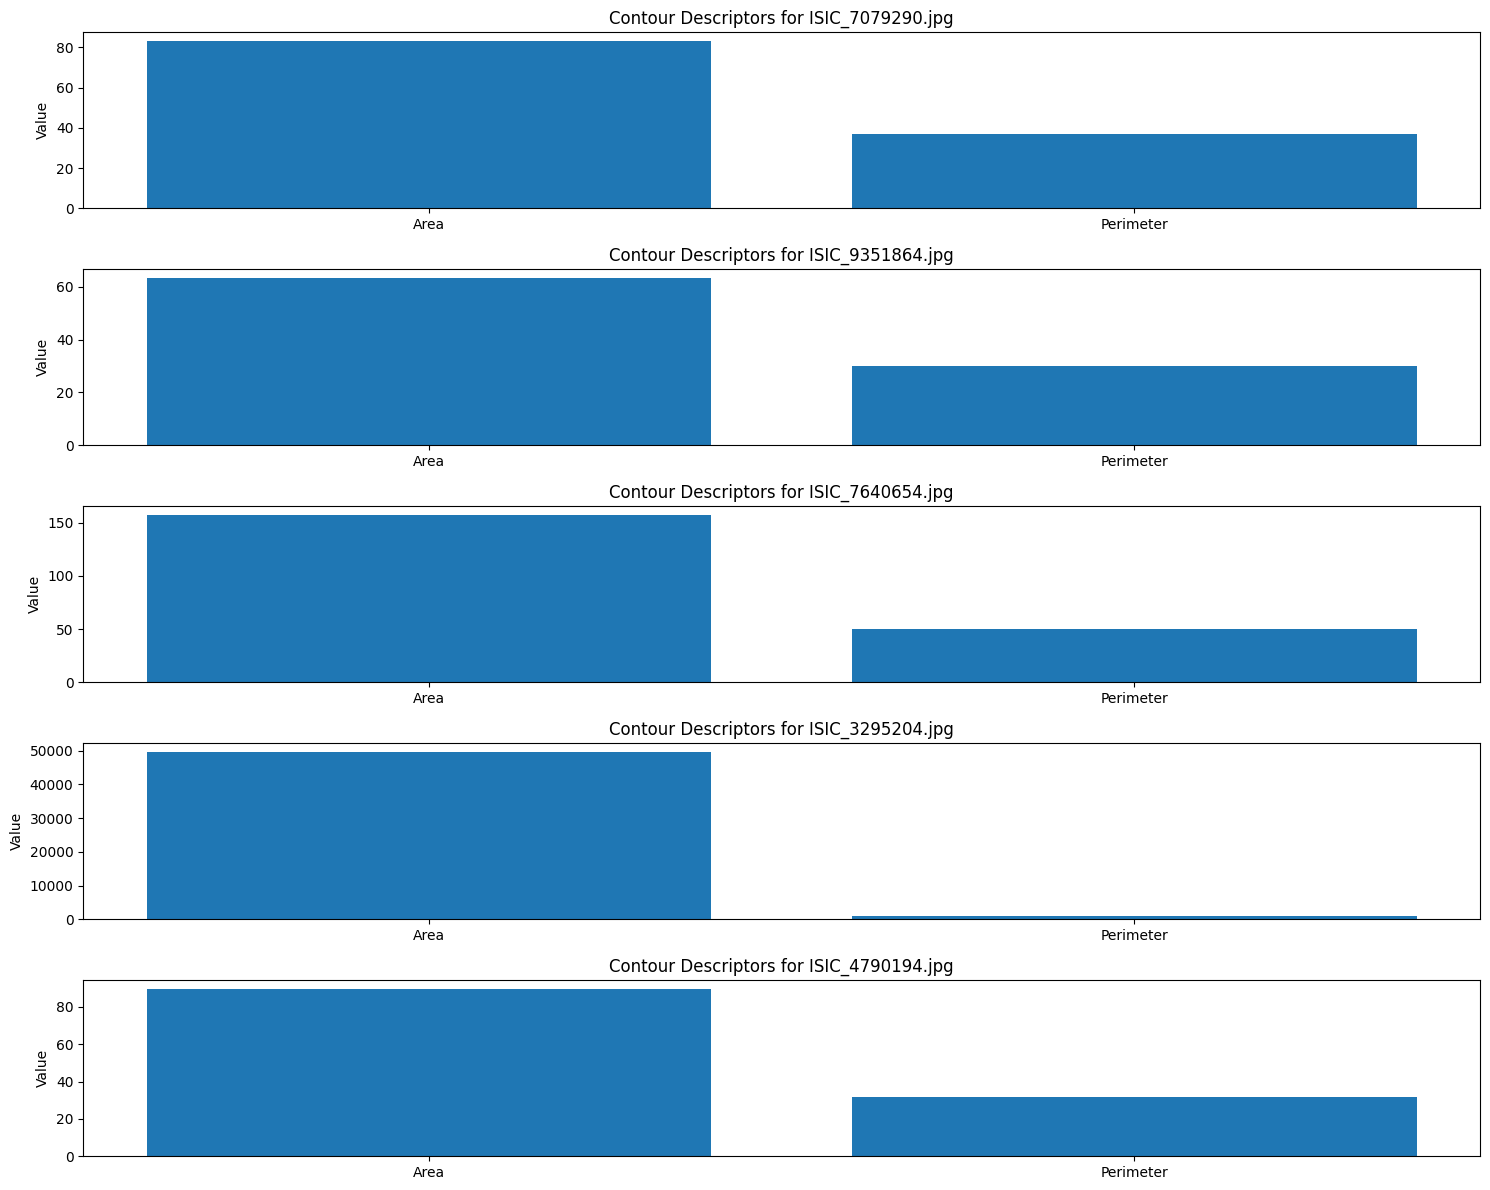

In [168]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

def list_images_in_subdirectories(base_folder_path):
    image_files = []
    for subdir, _, files in os.walk(base_folder_path):
        for file_name in files:
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Adjust extensions as needed
                image_files.append(os.path.join(subdir, file_name))
    return image_files

# Path to the base folder containing images in subdirectories
base_folder_path = '/kaggle/working/processed_images'

# List all images in the subdirectories
image_files = list_images_in_subdirectories(base_folder_path)

# Check if there are enough images
num_images_to_plot = 5
if len(image_files) < num_images_to_plot:
    raise ValueError("Not enough images to select from.")

# Select a subset of images to plot
selected_images = np.random.choice(image_files, num_images_to_plot, replace=False)

# Create subplots
plt.figure(figsize=(15, 12))

for idx, image_path in enumerate(selected_images):
    # Load the image
    image = cv2.imread(image_path)
    
    # Check if image is loaded successfully
    if image is None:
        print(f"Error loading image: {image_path}")
        continue
    
    # Convert to grayscale and binary
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    areas = []
    perimeters = []
    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        areas.append(area)
        perimeters.append(perimeter)
    
    # Plot contour-based descriptors
    plt.subplot(num_images_to_plot, 1, idx + 1)
    plt.bar(['Area', 'Perimeter'], [np.mean(areas), np.mean(perimeters)])
    plt.title(f'Contour Descriptors for {os.path.basename(image_path)}')
    plt.ylabel('Value')

# Adjust layout and show plots
plt.tight_layout()
plt.show()


In [25]:
print(mod_data.dtypes)

isic_id                          object
target                            int64
patient_id                       object
age_approx                      float64
sex                              object
anatom_site_general              object
clin_size_long_diam_mm          float64
image_type                       object
tbp_tile_type                    object
tbp_lv_A                        float64
tbp_lv_Aext                     float64
tbp_lv_B                        float64
tbp_lv_Bext                     float64
tbp_lv_C                        float64
tbp_lv_Cext                     float64
tbp_lv_H                        float64
tbp_lv_Hext                     float64
tbp_lv_L                        float64
tbp_lv_Lext                     float64
tbp_lv_areaMM2                  float64
tbp_lv_area_perim_ratio         float64
tbp_lv_color_std_mean           float64
tbp_lv_deltaA                   float64
tbp_lv_deltaB                   float64
tbp_lv_deltaL                   float64


# COPYING AND LABELLING DATA

In [38]:
import os
import shutil

# Define the source directory and subdirectories
source_dir = '/kaggle/working/split_images'
subdirs = ['train', 'val', 'test']
class_dirs = ['0', '1']

# Create class subdirectories for '0' and '1' inside each split directory
for split in subdirs:
    for class_name in class_dirs:
        os.makedirs(os.path.join(source_dir, split, class_name), exist_ok=True)

# Create a combined dictionary of targets from both dictionaries
combined_targets = {}
combined_targets.update(processed_targets)
combined_targets.update(augmented_targets)

# Function to move files to their respective directories based on the target values
def move_files_based_on_targets(directory, targets):
    for subdir in subdirs:
        subdir_path = os.path.join(directory, subdir)
        if os.path.exists(subdir_path):
            for root, _, files in os.walk(subdir_path):
                for file in files:
                    if file.endswith('.jpg'):
                        # Construct relative path of the image file
                        relative_path = os.path.relpath(os.path.join(root, file), subdir_path)
                        # Get target value for the image
                        target = targets.get(relative_path)
                        if target is not None:
                            class_subdir = str(target)  # Convert target to string to match directory name
                            dst_path = os.path.join(subdir_path, class_subdir, file)
                            src_path = os.path.join(root, file)
                            # Move file to the correct directory
                            shutil.move(src_path, dst_path)
                        else:
                            print(f"Target for image {file} not found. Skipping.")

# Move the files based on their targets
move_files_based_on_targets(source_dir, combined_targets)

print("Files sorted and moved successfully!")


Target for image ISIC_2342874.jpg not found. Skipping.
Target for image ISIC_1231941.jpg not found. Skipping.
Target for image ISIC_5259581.jpg not found. Skipping.
Target for image ISIC_0613775.jpg not found. Skipping.
Target for image ISIC_9668784.jpg not found. Skipping.
Target for image ISIC_8095825.jpg not found. Skipping.
Target for image ISIC_2924592.jpg not found. Skipping.
Target for image ISIC_0910019.jpg not found. Skipping.
Target for image ISIC_7057817.jpg not found. Skipping.
Target for image ISIC_8523921.jpg not found. Skipping.
Target for image ISIC_4188652.jpg not found. Skipping.
Target for image ISIC_9198709.jpg not found. Skipping.
Target for image ISIC_9136082.jpg not found. Skipping.
Target for image ISIC_5461283.jpg not found. Skipping.
Target for image ISIC_5129912.jpg not found. Skipping.
Target for image ISIC_4249547.jpg not found. Skipping.
Target for image ISIC_9476470.jpg not found. Skipping.
Target for image ISIC_5352838.jpg not found. Skipping.
Target for

In [182]:
# import os
# import shutil

# # Define the source directory and subdirectories
# source_dir = '/kaggle/working/split_images'
# subdirs = ['train', 'val', 'test']
# class_dirs = ['0', '1']

# # Function to delete directories and their contents
# def delete_directory_contents(directory):
#     if os.path.exists(directory):
#         for item in os.listdir(directory):
#             item_path = os.path.join(directory, item)
#             if os.path.isdir(item_path):
#                 shutil.rmtree(item_path)  # Remove the directory and all its contents
#             else:
#                 os.remove(item_path)  # Remove the file
#         print(f"Cleaned up directory: {directory}")

# # Delete existing directories and their contents
# for subdir in subdirs:
#     subdir_path = os.path.join(source_dir, subdir)
#     delete_directory_contents(subdir_path)

# print("Cleanup completed.")


Cleaned up directory: /kaggle/working/split_images/train
Cleaned up directory: /kaggle/working/split_images/val
Cleaned up directory: /kaggle/working/split_images/test
Cleanup completed.


# SETTING UP MODEL USING TRANSFER LEARNING

In [39]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load the ResNet50 model without the top layers
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# Load the manually downloaded weights
weights_path = '/kaggle/input/pre-trained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model.load_weights(weights_path)

# Add your custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data augmentation for validation and testing (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    directory='/kaggle/working/split_images/train',  # Path to train directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # Use 'binary' for binary classification
)

# Validation data generator
val_generator = val_test_datagen.flow_from_directory(
    directory='/kaggle/working/split_images/val',  # Path to validation directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # Use 'binary' for binary classification
)

# Test data generator
test_generator = val_test_datagen.flow_from_directory(
    directory='/kaggle/working/split_images/test',  # Path to test directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # Use 'binary' for binary classification
)


Found 1302 images belonging to 2 classes.
Found 434 images belonging to 2 classes.
Found 434 images belonging to 2 classes.


In [96]:
import os

def rename_images_with_missing_extensions(directory, new_extension='.jpg'):
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Only rename files without an extension or with an unsupported extension
            if not file.lower().endswith(('.jpg', '.png', '.jpeg')):
                new_name = file + new_extension
                os.rename(os.path.join(root, file), os.path.join(root, new_name))

# Apply this to your directories
rename_images_with_missing_extensions('/kaggle/working/processed_images/train')
rename_images_with_missing_extensions('/kaggle/working/processed_images/val')
rename_images_with_missing_extensions('/kaggle/working/processed_images/test')


In [41]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load ResNet50 model without pre-trained weights
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# Load the manually downloaded weights
weights_path = '/kaggle/input/pre-trained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'  # Replace with the path to your weights file
base_model.load_weights(weights_path)

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # For binary classification

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [48]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 317ms/step - accuracy: 0.5057 - loss: 0.7087 - val_accuracy: 0.5553 - val_loss: 0.6860
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5000 - loss: 0.7013 - val_accuracy: 0.4444 - val_loss: 0.7022
Epoch 3/50


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 311ms/step - accuracy: 0.4926 - loss: 0.7026 - val_accuracy: 0.5481 - val_loss: 0.6910
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.6797 - val_accuracy: 0.6111 - val_loss: 0.6875
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 308ms/step - accuracy: 0.5315 - loss: 0.6910 - val_accuracy: 0.5505 - val_loss: 0.6877
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5312 - loss: 0.6914 - val_accuracy: 0.5556 - val_loss: 0.6861
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 310ms/step - accuracy: 0.5336 - loss: 0.6877 - val_accuracy: 0.5457 - val_loss: 0.6903
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4375 - loss: 0.7016 - val_accuracy: 0.6667 - val_loss: 0.6775
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 302ms/step - accuracy: 0.5437 - loss: 0.6906 - val_accuracy: 0.4471 - val_loss: 0.6939
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5312 - loss: 0.6892 - val_accuracy: 0.5556 - val_los

In [49]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5298 - loss: 0.6913
Test Loss: 0.6922296285629272
Test Accuracy: 0.5216346383094788


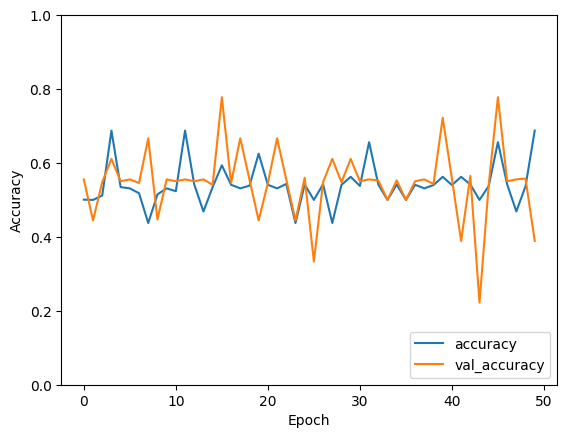

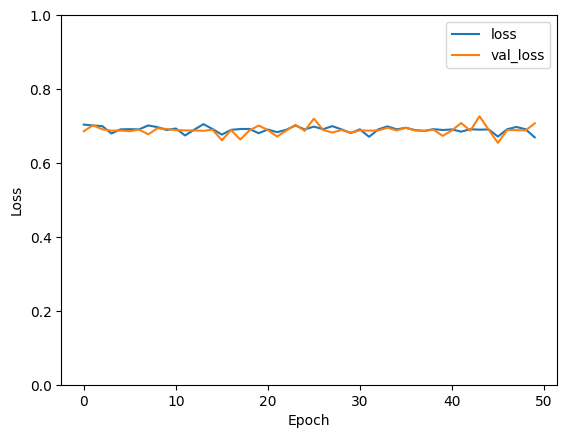

In [50]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.show()


In [51]:
# Generate predictions
test_predictions = model.predict(test_generator)
test_predictions = np.round(test_predictions).astype(int)  # Convert probabilities to binary labels


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


In [52]:
from sklearn.metrics import confusion_matrix

# True labels from the test generator
true_labels = test_generator.classes

# Compute confusion matrix
cm = confusion_matrix(true_labels, test_predictions)


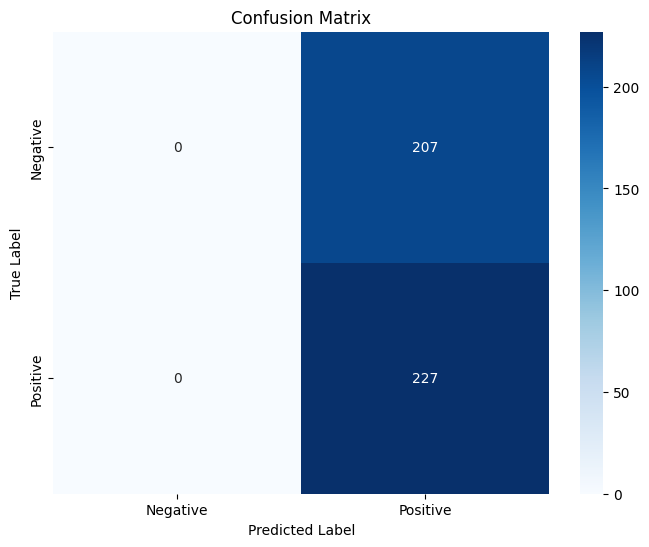

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
